# ToTTo Exploration

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import en_core_web_sm
import random

from transformers import T5Tokenizer
from spacy import displacy
from collections import Counter
from tqdm import tqdm

# Some matplotlib global parameters
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
sns.set_palette("deep")

## Average input and output length

Note that we calculate the source input that includes only the highlighted cells not the full table.

In [2]:
with open('../storage/datasets/totto/filtered/train.json') as f:
    dataset = json.load(f)
    
sources = [datapoint['subtable_and_metadata'] for datapoint in dataset]
targets = [datapoint['final_sentence'] for datapoint in dataset]

In [7]:
# We need to tokenize since just splitting will not return the true number of tokens
tokenizer = T5Tokenizer.from_pretrained('t5-small')

In [8]:
source_lens = np.array([len(tokenizer.tokenize(source)) for source in sources])

target_lens = np.array([len(tokenizer.tokenize(target)) for target in targets])

print(f"Mean source length: {np.mean(source_lens)} | Std: {np.std(source_lens)}\nMean target length: {np.mean(target_lens)} | Std: {np.std(target_lens)}") 

Mean source length: 223.59387716358654 | Std: 1506.6134405026614
Mean target length: 23.86104347395442 | Std: 9.964455109419083


**Distribution Visualization**

Concerning distribution visualization we notice a number of outliers on the sources. For example, there are 2 tables that consist of more than 200,000 tokens.
In order for the visualization to be interpretable we clip all the table sources that have more than 2,000 tokens to 2,000. This also explains the high std (1,506) above. 

In total we clip 617 tables out of the 121153 (0.5%).

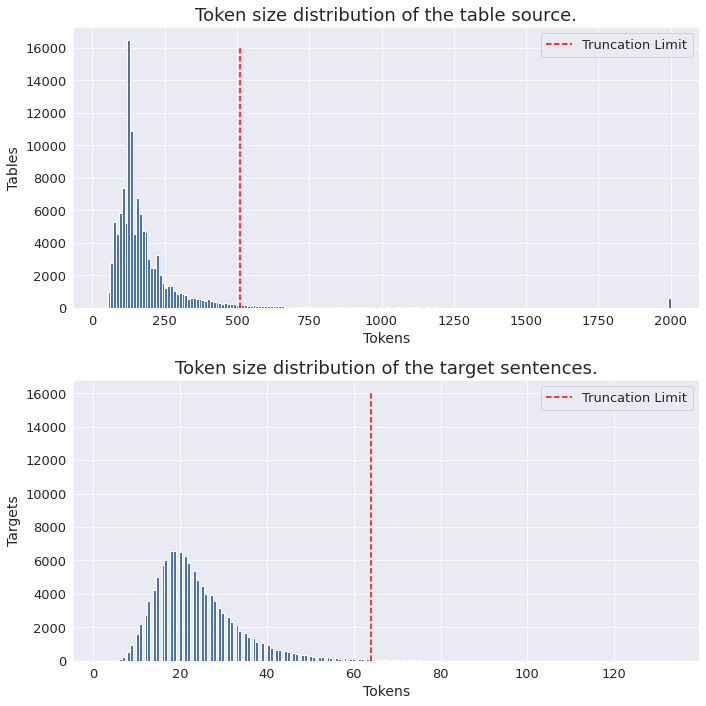

In [47]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.hist(np.clip(source_lens, a_max=2_000, a_min=None), 200)
plt.vlines(512, ymin=0, ymax=16_000, linestyles='dashed', color="red", label="Truncation Limit")
plt.legend()

plt.ylabel("Tables")
plt.xlabel("Tokens")
plt.title("Token size distribution of the table source.")

plt.subplot(2, 1, 2)
plt.hist(np.clip(target_lens, a_max=None, a_min=0), 200)
plt.vlines(64, ymin=0, ymax=16_000, linestyles='dashed', color="red", label="Truncation Limit")
plt.legend()

plt.ylabel("Targets")
plt.xlabel("Tokens")
plt.title("Token size distribution of the target sentences.")

plt.tight_layout()

plt.savefig('../storage/plots/totto/token_distributions.png', format='png', dpi=800, bbox_inches = 'tight')
plt.show()

We can see that in most cases our specified limits (red lines) do not truncate the input or ouput of the model.

## Entity Analysis

Our main goal is generating NL which explains the results of a query. Since there is not an explicit dataset on our task, we assume that there is an alignment between the ToTTo dataset. However, the alignment is not exact. For example, ToTTo may need many rows to produce one answer. While, we can deal with most of these problems a we must examine if the ToTTo domain matches our unknown query_result2text domain.

By observing some of the target sentences we immediately notice a high frequency of named entities (eg. Persons). This is expected since these tables are parsed from Wikipedia articles that normally describe a person, an event or a location. We examine the frequency of these entities in order to have an estimate of the alignment of the two domains.

In [4]:
# These are the enities that if a sentence contains it will get filtered out
# Intuitevely, these are entities that we do not expect to observe in databases frequently
kept_entities = set(['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'EVENT', 'LOC'])

def keep_entity(target_entities, kept_entities):
    for ent in target_entities.ents:
        if ent.label_ in kept_entities:
            return False
    return True

ne_extractor = en_core_web_sm.load()

In [64]:
named_entities = [ne_extractor(sent) for sent in targets]
filtered_entities = list(filter(lambda x: keep_entity(x, kept_entities), named_entities))

In [68]:
percent_kept = len(filtered_entities) / len(targets) * 100

print(f"Percentage of target sentences not containing entities: {np.round(percent_kept, decimals=2)}% ({len(filtered_entities)})")

Percentage of target sentences not containing entities: 8.25% (9997)


We can see thatn only 8% of the dataset does not contain an entity on its target description. However, since this is a sizeable dataset this set consists of 10K datapoints.

Some solutions:
* Just train on the 8% which does not contain named entities
* Train on the non-entity set and on a small sample (eg. 10%) of the sentences that contain named entities

**Creating the sampled dataset**

For validation.

In [15]:
file_name = "dev.json"  # train.json or dev.json

with open(f'../storage/datasets/totto/filtered/{file_name}') as f:
    dataset = json.load(f)
    
non_entity_datapoints = []
entity_datapoints = []

for datapoint in tqdm(dataset):
    if keep_entity(ne_extractor(datapoint['final_sentence']), kept_entities):
        non_entity_datapoints.append(datapoint)
    else:
        entity_datapoints.append(datapoint)

100%|██████████| 22293/22293 [01:08<00:00, 323.26it/s]


In [16]:
entity_datapoints_sample = random.sample(entity_datapoints, k=len(non_entity_datapoints))
sampled_dataset = non_entity_datapoints + entity_datapoints_sample
random.shuffle(sampled_dataset)

with open(f'../storage/datasets/totto/filtered_sampled/{file_name}', 'w') as outfile:
    json.dump(sampled_dataset, outfile)

In [17]:
print(len(sampled_dataset))

3662


For evaluation.

In [5]:
file_name = "evaluation.json"  # train.json or dev.json

with open(f'../storage/datasets/totto/filtered/{file_name}') as f:
    dataset = json.load(f)
    
non_entity_datapoints = []
entity_datapoints = []

for datapoint in tqdm(dataset):
    if keep_entity(ne_extractor(datapoint['final_sentence'][0]), kept_entities):
        non_entity_datapoints.append(datapoint)
    else:
        entity_datapoints.append(datapoint)
        
entity_datapoints_sample = random.sample(entity_datapoints, k=len(non_entity_datapoints))
sampled_dataset = non_entity_datapoints + entity_datapoints_sample
random.shuffle(sampled_dataset)

with open(f'../storage/datasets/totto/filtered_sampled/{file_name}', 'w') as outfile:
    json.dump(sampled_dataset, outfile)

100%|██████████| 7700/7700 [00:28<00:00, 266.97it/s]
